# Face Detection with MediaPipe Tasks

This notebook shows you how to use the MediaPipe Tasks Python API to detect faces in images.

## Visualization utilities

To better demonstrate the Face Detector API, we have created a set of visualization tools that will be used in this colab. These will draw a bounding box around detected faces, as well as markers over certain detected points on the faces.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2


def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]

        # Draw the face landmarks.
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])

        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_iris_connections_style())

    return annotated_image


def plot_face_blendshapes_bar_graph(face_blendshapes):
    # Extract the face blendshapes category names and scores.
    face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
    face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
    # The blendshapes are ordered in decreasing score value.
    face_blendshapes_ranks = range(len(face_blendshapes_names))

    fig, ax = plt.subplots(figsize=(12, 12))
    bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
    ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
    ax.invert_yaxis()

    # Label each bar with values
    for score, patch in zip(face_blendshapes_scores, bar.patches):
        plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

    ax.set_xlabel('Score')
    ax.set_title("Face Blendshapes")
    plt.tight_layout()
    plt.show()

## Download test image

To demonstrate Face Detection, you can download a sample image using the following code. Credits: https://pixabay.com/photos/brother-sister-girl-family-boy-977170/

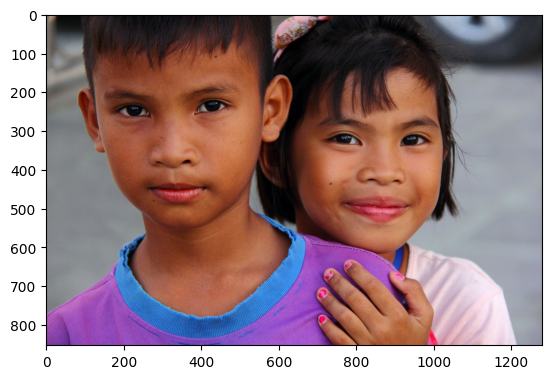

In [18]:
!curl https://i.imgur.com/Vu2Nqwb.jpeg -s -o image.jpg

IMAGE_FILE = 'image.jpg'

import cv2

img = cv2.imread(IMAGE_FILE)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Optionally, you can upload your own image from your computer. To do this, uncomment the following code cell.

## Running inference and visualizing the results

The final step is to run face detection on your selected image. This involves creating your FaceDetector object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

You can check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_detector/python) to learn more about configuration options that this solution supports.

I0000 00:00:1717577372.125504 1105088 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1717577372.125664 1105088 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1717577372.128317 1105347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717577372.134349 1105347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '

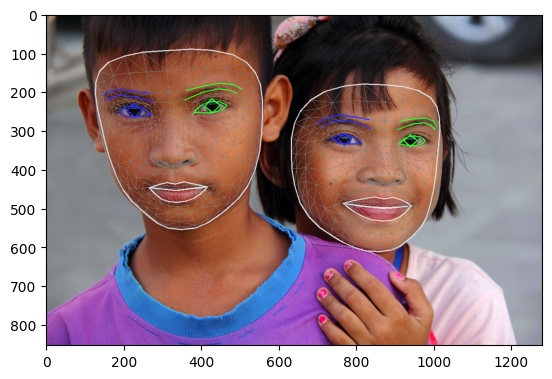

In [19]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='../../data/mediapipe/face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=2)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(annotated_image)

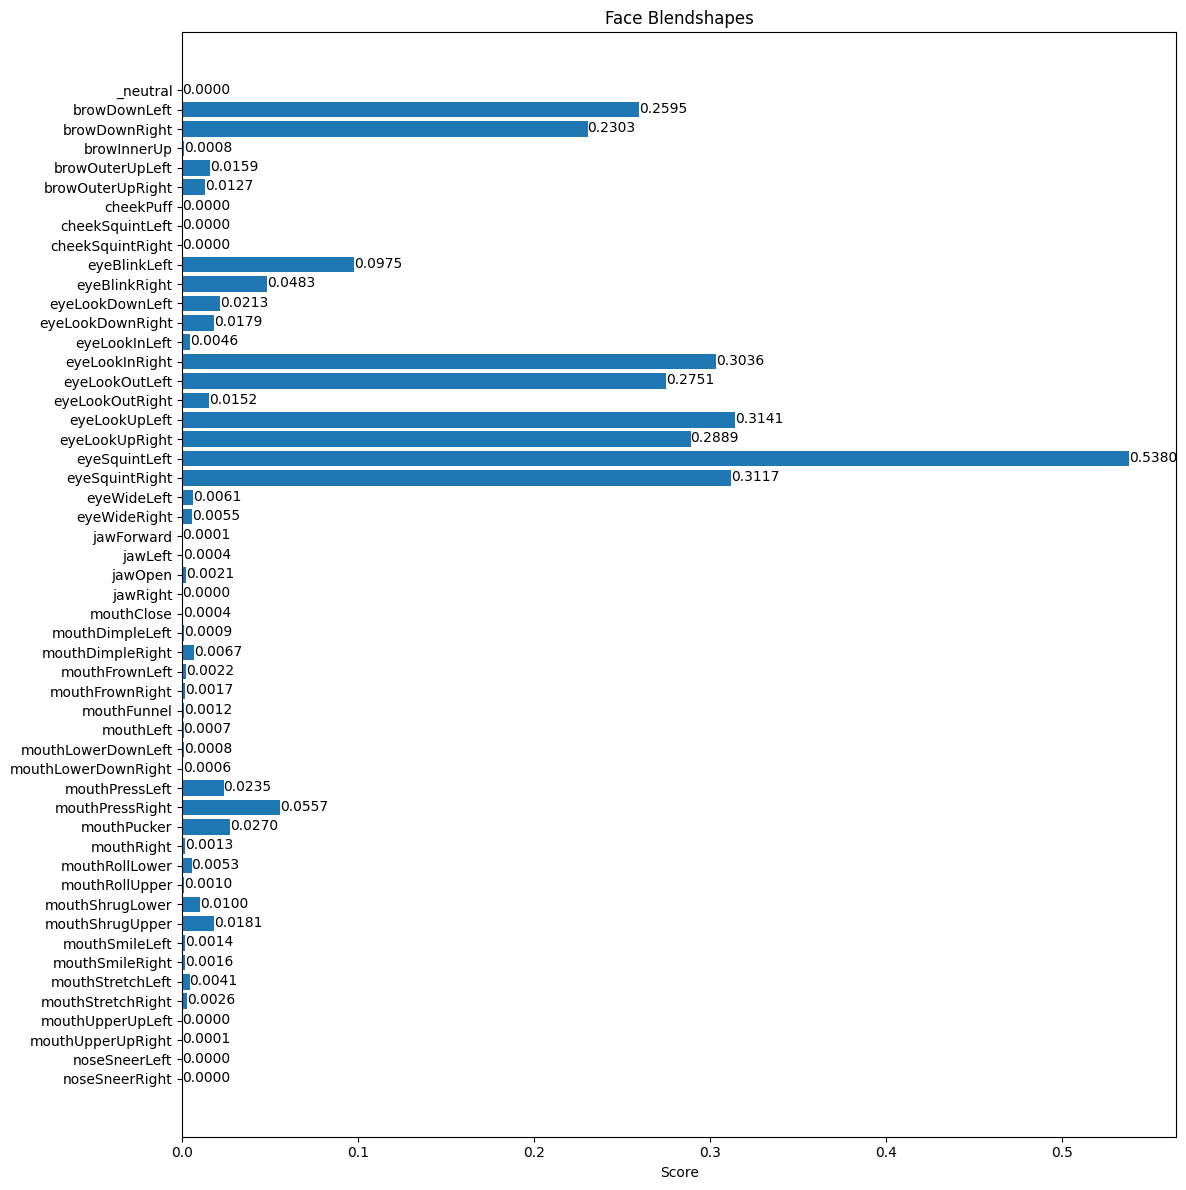

In [20]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [21]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.99779522e-01,  6.98518660e-03,  1.97864007e-02,
        -1.01819105e+01],
       [-4.46200313e-04,  9.49827075e-01, -3.12774390e-01,
         4.42689133e+00],
       [-2.09785085e-02,  3.12696815e-01,  9.49621081e-01,
        -2.64568405e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), array([[ 9.93841171e-01,  2.08371901e-03,  1.10793345e-01,
         7.44385242e+00],
       [ 1.25875045e-02,  9.91228998e-01, -1.31554276e-01,
         1.64181960e+00],
       [-1.10095724e-01,  1.32138819e-01,  9.85097885e-01,
        -2.83312817e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]
